# Facial Expression Recognition - Using FER2013 Database and Transfer Learning
**Author**: Christopher Holzweber

**Institution**: Johannes Kepler Universität Linz - Institute of Computational Perception

**Intention**: Bachelorthesis - Prototype for FER

**Description**: 
In this Notebook File a CNN Model is trained using the FER2013 Dataset and Transfer Learning



**Required Installations**:

Tensorflow: pip install tensorflow

Numpy: pip install numpy

OpenCV: pip install opencv-python

Matplotlib: python -m pip install -U matplotlib

Pandas: pip install pandas

Seaborn: pip install seaborn

Keras Applications: pip install keras_applications

In [1]:
# %tensorflow_version 2.x  # making sure using version 2 of tensorflow
import tensorflow as tf  # import tensorflow module
import numpy as np # standard lib. for calculations
import cv2  # library for imagehandling 
import matplotlib.pyplot as plt  # plotting images
import os  # for file handling and loading
import pandas as pd
import random # for datashuffling
from sklearn.metrics import confusion_matrix, plot_roc_curve # for evaluationg the CNN Models
import seaborn as sn # pi install seaborn - used for plotting confusion matrix

# Dataset
For this model the dataset FER2013 is used

https://www.kaggle.com/msambare/fer2013

The data is already seperated into a test and a train dataset.

The FER2013 set classifies facial emotions into 7 Categories:

(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [2]:
  # !unzip FER2013 # if training in google colab - upload zip file of FER2013 and unzip

**Define Classes and Data/Label Arrays**

In [3]:
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
IMG_SIZE = 224 #set pixel size of image, images are used to be IMG_SIZExIMG_SIZE
imagetype = 1 # 0 for grayscale, 1 for rgb
train_data = [] # picture data for model training
train_label = [] # labels of training data
test_data = [] # picture data for model testing
test_label = []  # labels of testing data

**Read all  Images from subfolders and return data  + label tuples**

The readData Method reads all Files from a given directory, consisting of Labeled Subfoldes. e.g. FER2013/0/xyz.png

In [4]:
def readData(directory,nrsubfolders):
    dataframe = []
    traindir = directory
    for cs in range(0, nrsubfolders):
        path = os.path.join(traindir,str(cs))  # Iterate over every subfolder
        for img in os.listdir(path):
            tempImg = cv2.imread(os.path.join(path,img),imagetype) #readImg
            tempImg = cv2.resize(tempImg, (IMG_SIZE, IMG_SIZE)) #resize to IMG_SIZE
            dataframe.append([tempImg,cs]) #append tuple to dataframe
    return dataframe

**Load all training and test images - shuffle them and normalize them**

In [5]:
tempdata = readData("./FER2013/train/",len(emotion_classes)) # read training data
random.shuffle(tempdata) #shuffle data
#store data in according arrays, seperating the created tuples 
for feat,label in tempdata:
    train_data.append(feat)
    train_label.append(label)
tempdata = readData("./FER2013/test/",len(emotion_classes)) # read testing data
random.shuffle(tempdata) #shuffle data
#store data in according arrays
test_data = None
test_data = []
for feat,label in tempdata:
    test_data.append(feat)
    test_label.append(label)

# create arrays out of lists
train_data = np.array(train_data)
train_label = np.array(train_label)
test_data = np.array(test_data)
test_label = np.array(test_label)


In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomCrop(IMG_SIZE,IMG_SIZE)
])

In [7]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input  #preprocess with renet_v2 preprocessor

In [8]:
# pip install keras_applications #needed to install, for using VGGFace pretrained model

In [9]:
from tensorflow.keras import layers, models  # use models and layers given by tensorflow framework
from keras_vggface.vggface import VGGFace #https://www.robots.ox.ac.uk/~vgg/data/vgg_face/

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
base_model = VGGFace(input_shape=IMG_SHAPE,
                    include_top=False,
                    weights='vggface')

In [11]:
# Freeze Base Model before compilation and training
base_model.trainable = False

In [12]:
base_model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

# Setup CNN Archtiecture with VGGFace pretrained model

In [13]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x) 
x = base_model(x, training=False)

#Backend
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(7, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [14]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay = 0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
vggface_vgg16 (Functional)   (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0     

In [16]:
history = model.fit(train_data, train_label,
                    epochs=4,
                    validation_data=(test_data, test_label))

Epoch 1/4
898/898 [==============================] - 185s 164ms/step - loss: 1.5853 - accuracy: 0.4745 - val_loss: 1.0651 - val_accuracy: 0.6128
Epoch 2/4
898/898 [==============================] - 152s 169ms/step - loss: 1.0830 - accuracy: 0.6043 - val_loss: 1.0154 - val_accuracy: 0.6197
Epoch 3/4
898/898 [==============================] - 152s 170ms/step - loss: 0.9918 - accuracy: 0.6371 - val_loss: 0.9893 - val_accuracy: 0.6300
Epoch 4/4
898/898 [==============================] - 152s 169ms/step - loss: 0.9188 - accuracy: 0.6615 - val_loss: 0.9782 - val_accuracy: 0.6408


In [17]:
model.save('model_vggface_fer2013_p224_dim3.h5')

# *Testing and Validation Area of Model2020*

In [18]:
#acc = history.history['accuracy']

In [19]:
#test_loss, test_acc = model.evaluate(test_data, test_label, verbose=2)

## Create Confusion Matrix of trained model

In [20]:
def getConfusionMatrix(model):
    predicted = model.predict(test_data)
    y_pred = []
    for i in range(0, len(test_label)):
        y_pred.append(np.argmax(predicted[i,:]))
    y_pred = np.array(y_pred)
    return confusion_matrix(test_label, y_pred)

In [21]:
def printConfusionMatrix(model):
    conmatrix = getConfusionMatrix(model)
    df_cm = pd.DataFrame(conmatrix, index = [i for i in "0123456"],
                  columns = [i for i in "0123456"])

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True,fmt="d")
    plt.title('Confusion Matrix of CNN Model')
    # Set x-axis label
    plt.xlabel('Predicted')
    # Set y-axis label
    plt.ylabel('Actual')

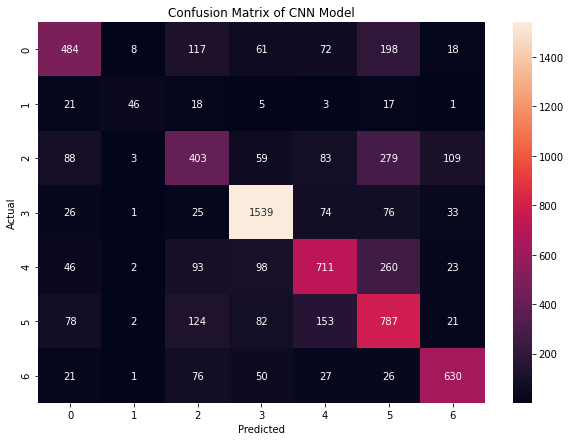

In [22]:
printConfusionMatrix(model)